This notebook was created for exploring the questions posed in: https://www.quantamagazine.org/20160913-the-physics-of-time-puzzle/

No answers to the questions are given here, only a way to perform the simulations. I am not affiliated with Quanta Magazine or the author of the above article in any way.

The first five cells of this notebook contain my implementation of the simulation structure in Python. The final three cells demonstrate how to actually perform some simulations.

In [1]:
import numpy as np
from matplotlib.lines import Line2D as l2d
import matplotlib.pyplot as plt

In [2]:
def get_neighbor_points(pt):
    grid_x_bounds = range(6)   # [0,1, ... ,5]
    grid_y_bounds = range(5)   # [0,1, ... ,4]
    x = pt[0]
    y = pt[1]
    
    possible_neighbors = [(x+dx, y) for dx in (-1,1)]
    possible_neighbors.extend([(x, y+dy) for dy in (-1,1)])
    
    neighbors = []
    for pn in possible_neighbors:
        if pn[0] in grid_x_bounds and pn[1] in grid_y_bounds:
            neighbors.append(pn)
    return neighbors

In [3]:
class AtomBar(object):
    def __init__(self, pt0, pt1):
        self.pt0 = pt0
        self.pt1 = pt1
        self.iteration = 0
        
    @property
    def points(self):
        return (self.pt0, self.pt1)
    
    def move(self):
        # Choose which point to move first
        pt = np.random.choice((0,1))
        pt = self.pt0 if pt == 0 else self.pt1
        
        # Get possible neighbor points of this point
        valid_neighbors = get_neighbor_points(pt)
        
        # Choose random neighbor point
        chosen_pt = valid_neighbors[np.random.choice(list(range(len(valid_neighbors))))]
        
        # Repeat and choose random neighbor of the new point
        other_neighbors = get_neighbor_points(chosen_pt)
        other_chosen_pt = other_neighbors[np.random.choice(list(range(len(other_neighbors))))]
        
        # Update instance variables accordingly
        if pt == self.pt0:
            self.pt0 = chosen_pt
            self.pt1 = other_chosen_pt
        else:
            self.pt1 = chosen_pt
            self.pt0 = other_chosen_pt
        self.iteration += 1

In [4]:
class UniverseBoard(object):
    BLANK_LW = 1
    BLANK_COLOR = 'blue'
    ATOM_LW = 3
    ATOM_COLOR = 'red'
    INITIAL_POINT_PAIRS = (((2,1), (3,1)),
                           ((2,1), (2,2)),
                           ((3,1), (3,2)),
                           ((3,2), (3,3)),
                           ((3,2), (2,2)),
                           ((3,3), (2,3)),
                           ((2,2), (2,3))
                          )
    INITIAL_NODES = ((2,1), (3,1), (2,2), (3,2), (3,3), (2,3))
    ALT_POINT_PAIRS = (((2,0), (3,0)),
                       ((1,1), (1,2)),
                       ((4,1), (4,2)),
                       ((4,2), (4,3)),
                       ((4,2), (5,2)),
                       ((3,4), (2,4)),
                       ((1,2), (1,3))
                      )
    
    def __init__(self, stratified_stability=False):
        self.grid_lines = {}
        self.stratified_stability = stratified_stability
        self.atoms = self._init_game_board_atoms(stratified_stability)
        self._set_atom_positions(self.atoms)
        self.iteration = 0
        self.filled_init_points = []
        self.frozen_atoms = []
        if stratified_stability:
            self._entropy = (1,0)
        else:
            self._entropy = (0,0)
        
    @property
    def entropy(self):
        # Return previously calculated value if we have it for this iteration        
        if self._entropy[1] == self.iteration:
            return self._entropy[0]
        
        u = 0
        t = 0
        b = 0
        for ipt in self.INITIAL_POINT_PAIRS:
            lcd_segment = self.grid_lines[ipt]
            if lcd_segment:
                b += len(lcd_segment)
            else:
                u += 1
                
        checked_segments = []
        for k,v in self.grid_lines.items():
            if k in checked_segments:
                continue
            
            # Not an original line segment, but shares a single node
            # with an original line segment
            if ((k not in self.INITIAL_POINT_PAIRS
                 and (k[1],k[0]) not in self.INITIAL_POINT_PAIRS)
                 and (k[0] in self.INITIAL_NODES 
                      or k[1] in self.INITIAL_NODES)):
                t += len(v)
            checked_segments.append(k)
            checked_segments.append((k[1],k[0]))
        
        etrp = (14 + 4*u - 2*b - t)/42
        self._entropy = (etrp, self.iteration)
        return etrp
            
        
    def _init_game_board_atoms(self, stratified_stability):
        atoms = []
        if stratified_stability:
            ipts = self.ALT_POINT_PAIRS
        else:
            ipts = self.INITIAL_POINT_PAIRS
        for pp in ipts:
            atoms.append(AtomBar(pp[0], pp[1]))
        return atoms
    
    def _init_grid_lines(self):
        for x in range(6):
            pt_prev = None
            for y in range(5):
                pt = (x,y)
                if pt_prev is not None:
                    self.grid_lines[(pt_prev,pt)] = []
                    self.grid_lines[(pt,pt_prev)] = []
                pt_prev = pt
        
        for y in range(5):
            pt_prev = None
            for x in range(6):
                pt = (x,y)
                if pt_prev is not None:
                    self.grid_lines[(pt_prev,pt)] = []
                    self.grid_lines[(pt,pt_prev)] = []
                pt_prev = pt
    
    def update(self):        
        if self.stratified_stability:
            for atm in self.atoms:
                in_init_segment = (atm.points in self.INITIAL_POINT_PAIRS
                                   or (atm.points[0], atm.points[1]) 
                                        in self.INITIAL_POINT_PAIRS)
                if in_init_segment:
                    if atm.points in self.filled_init_points:
                        if atm in self.frozen_atoms:
                            # Don't update frozen atoms
                            pass
                        else:
                            # Segment is already filled by another atom
                            atm.move()
                    else:
                        # Freeze in place on this segment
                        self.filled_init_points.append(atm.points)
                        self.frozen_atoms.append(atm)
                else:
                    atm.move()
        else:
            for atm in self.atoms:
                atm.move()
        self._set_atom_positions(self.atoms)
        self.iteration += 1
    
    def _set_atom_positions(self, atoms):
        self._init_grid_lines()
        for atm in atoms:
            pt0 = atm.pt0
            pt1 = atm.pt1
            # Allow for multiple Atoms to occupy same grid line
            if self.grid_lines[(pt0,pt1)]:
                self.grid_lines[(pt0,pt1)].append(atm)
                self.grid_lines[(pt1,pt0)].append(atm)
            else:
                self.grid_lines[(pt0,pt1)] = [atm]
                self.grid_lines[(pt1,pt0)] = [atm]
    
    def draw(self):
        fig = plt.gcf()
        ax = fig.gca(frameon=False)
        ax.set_xticks(())
        ax.set_yticks(())
        
        drawn = []
        for k,v in self.grid_lines.items():
            if k not in drawn and (k[1],k[0]) not in drawn:
                if abs(k[0][0] - k[1][0]):
                    # horizontal line
                    x0 = min(k[0][0],k[1][0])
                    xmax = max(k[0][0],k[1][0])
                    
                    # different color and width if an Atom on line
                    if v:
                        ax.add_line(l2d([x0,xmax],[k[0][1],k[0][1]],color=self.ATOM_COLOR,
                                   lw=self.ATOM_LW,
                                   ls='solid'))
                    else:
                        ax.add_line(l2d([x0,xmax],[k[0][1],k[0][1]],color=self.BLANK_COLOR,
                                   lw=self.BLANK_LW,
                                   ls='solid'))
                else:
                    # vertical line
                    y0 = min(k[0][1],k[1][1])
                    ymax = max(k[0][1],k[1][1])
                    
                    if v:
                        ax.add_line(l2d([k[0][0],k[0][0]],[y0,ymax],color=self.ATOM_COLOR,
                                   lw=self.ATOM_LW,
                                   ls='solid'))
                    else:
                        ax.add_line(l2d([k[0][0],k[0][0]],[y0,ymax],color=self.BLANK_COLOR,
                                   lw=self.BLANK_LW,
                                   ls='solid'))
                drawn.append(k)
                drawn.append((k[1],k[0]))
        ax.set_xlim(-0.15,5.15)
        ax.set_ylim(-0.15,4.15)
        fig.set_frameon(False)
        ts = 'Stratified stability: {}\n'.format(self.stratified_stability)
        ts += 'Iteration: {}\nEntropy: {}\n'.format(self.iteration,
                                                round(self.entropy,4))
        plt.title(ts)
        plt.show()
        return fig, ax

Create a universe with stratified stability disabled and perform a few iterations.

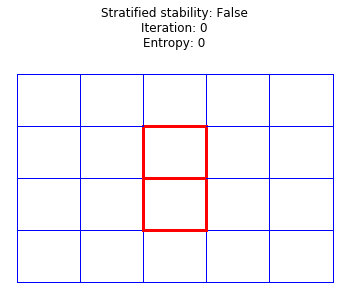

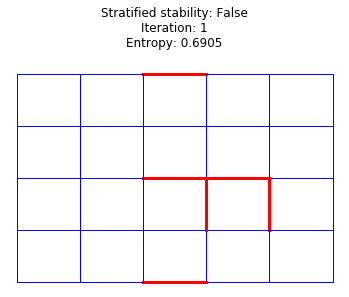

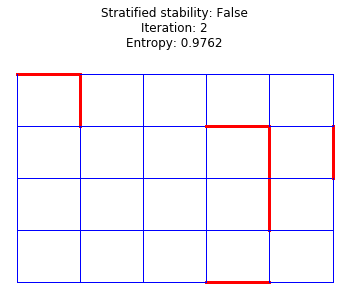

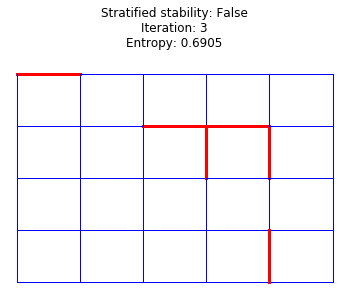

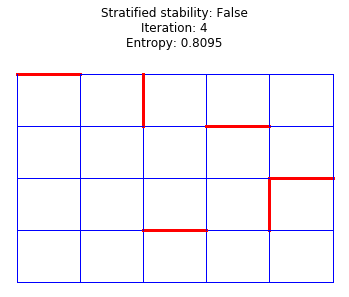

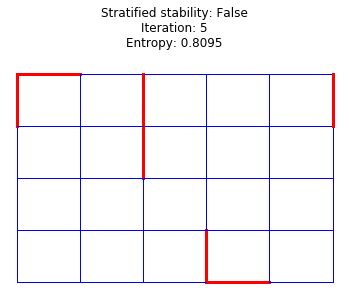

In [5]:
universe_wo_stability = UniverseBoard()
universe_wo_stability.draw()
for i in range(5):
    universe_wo_stability.update()
    universe_wo_stability.draw()

Create a universe with stratified stability enabled and perform a few iterations.

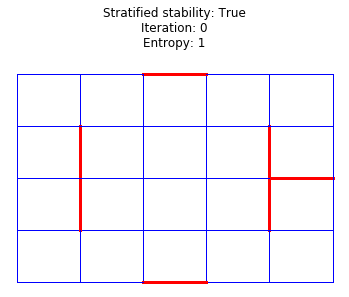

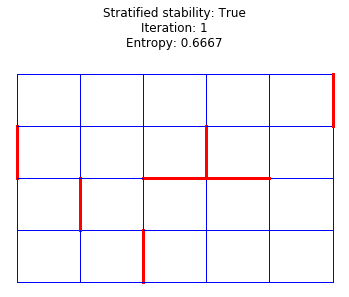

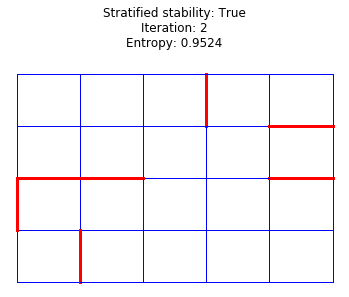

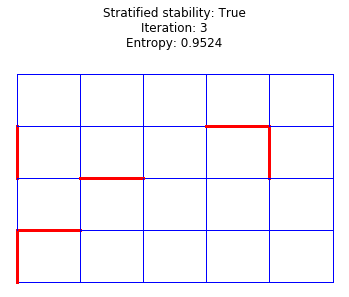

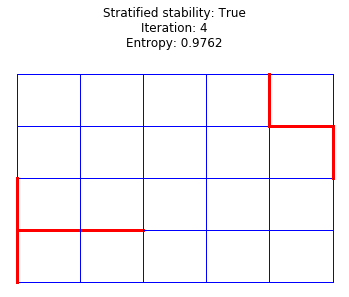

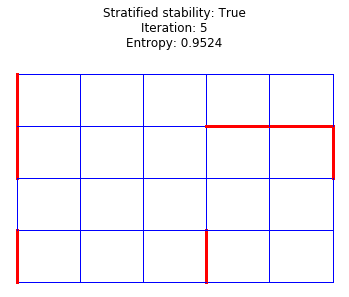

In [6]:
universe_with_stability = UniverseBoard(True)
universe_with_stability.draw()
for i in range(5):
    universe_with_stability.update()
    universe_with_stability.draw()

The below section will perform up to `num_max_iterations` for a universe. The graph of the universe state is displayed along with summary information every `num_max_iterations/5` iterations.

`stratified_stability` controls whether the universe obeys stratified stability (`True`) or not (`False`).

Min ent: 0.4762, Max ent: 0.4762, Full ent count: 0


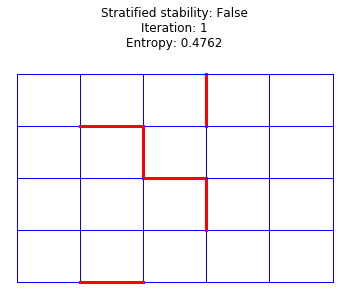

Min ent: 0.3571, Max ent: 0.9524, Full ent count: 107


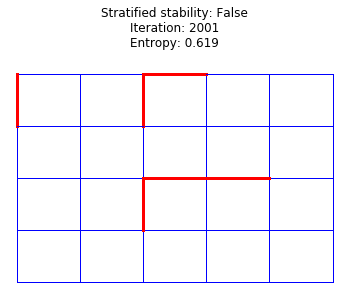

Min ent: 0.3571, Max ent: 0.9762, Full ent count: 197


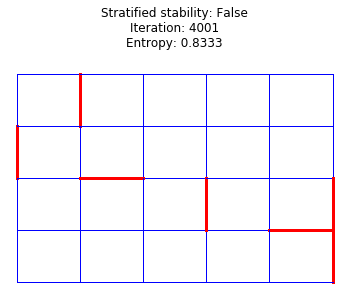

Min ent: 0.3571, Max ent: 0.9762, Full ent count: 290


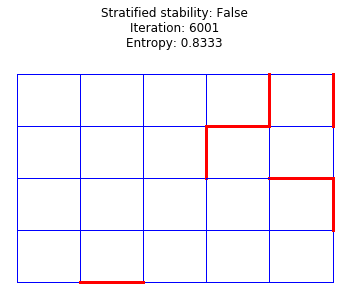

Min ent: 0.3571, Max ent: 0.9524, Full ent count: 406


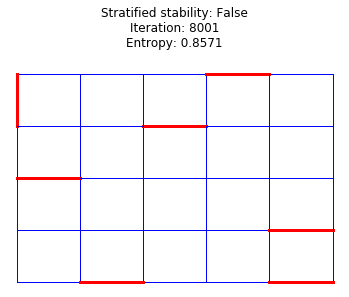

Min ent: 0.2857, Max ent: 0.8095, Full ent count: 525


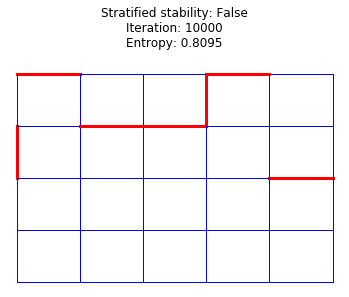

In [7]:
ub = UniverseBoard(stratified_stability=False)
min_ent = 100
max_ent = 0

# Number of times that maximum entropy (1.0) was reached.
num_full_ent_hits = 0

num_max_iterations = 10000
print_status_batch_size = num_max_iterations/5
for i in range(num_max_iterations):
    ub.update()
    etrp = ub.entropy
    if etrp < min_ent:
        min_ent = etrp
        if etrp == 0.0:
            break
    if etrp > max_ent:
        max_ent = etrp
        if etrp == 1.0:
            num_full_ent_hits += 1
            max_ent = 0
    if not i % print_status_batch_size:
        print('Min ent: {}, Max ent: {}, Full ent count: {}'.format(
                round(min_ent,4), round(max_ent,4), num_full_ent_hits))
        ub.draw()

print('Min ent: {}, Max ent: {}, Full ent count: {}'.format(
            round(min_ent,4), round(max_ent,4), num_full_ent_hits))
ub_figure, ub_axis = ub.draw()